# GitHub Data for OpenShift Origins

In this notebook we will quickly walk through how to access and start analyzing the PR data for the OpenShift origins repository. We also explore the various fields in the PR dataset and the features that we can derive from them in order to frame an [ML problem](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) where we predict the time taken to merge a PR.  

The ultimate hope for this work is that we will be able to connect the Github data (code changes) directly with the Bugs, Telemetry, TestGrid and Prow datasets in order to develop a complete picture of the OpenShift CI process.   

## Data Collection:

The Thoth team already developed a tool for collecting data and perfoming analysis on GitHub repositoreis, [MI-Scheduler](https://github.com/thoth-station/mi-scheduler). So, we will not be accessing the data directly from GitHub, but from ceph storage after requesting that the OpenShift/Origin repo be included in the MI-Scheduler tool (see [issue](https://github.com/thoth-station/mi-scheduler/issues/130) for details).    

In [1]:
import os
import gzip
import json
import boto3
import pathlib
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS

from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (20, 10)})

In [2]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "metrics")
s3_input_data_path = "raw_data"
REMOTE = os.getenv("REMOTE")

In [4]:
data_path = "../../../data/raw/GitHub/PullRequest.json.gz"

if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, "thoth/mi/openshift/origin/PullRequest.json")
    file = content.get()["Body"].read().decode("utf-8")
    prs = json.loads(file)

    with gzip.open(data_path, "wb") as out_file:
        out_file.write(json.dumps(prs).encode("utf-8"))

else:
    print("getting dataset from local")
    with gzip.open(data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))


pr_df = pd.DataFrame(prs).T

getting dataset from local


In [5]:
pr_df.shape

(17183, 15)

In [6]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files
26100,bug 1949306: add e2e test to block usage of re...,Right now this is set to flake in CI and provi...,XXL,deads2k,1619104429,1619253940,openshift-merge-robot,1619253940,2,135,"{'deads2k': 1, 'openshift-ci-robot': 307, 'stt...",{},"[approved, bugzilla/severity-urgent, bugzilla/...","[13b0e99d5f35d85998af9f07eb0c5b7d6fcc0dd0, 0c3...","[go.mod, go.sum, test/extended/apiserver/api_r..."
26099,bug 1951705: allow HighOverallControlPlaneCPU ...,adding the alert in https://github.com/openshi...,XS,deads2k,1619091511,1619113470,openshift-merge-robot,1619113470,1,1,"{'openshift-ci-robot': 508, 'deads2k': 43, 'op...",{},"[approved, bugzilla/severity-high, bugzilla/va...",[7bc10c83eea29010f3b735c41847d43a992f606c],[test/extended/prometheus/prometheus.go]


## Inspect the dataset

Let's unroll a single row and see what kind of information we have access to. 

In [7]:
pr = pr_df.iloc[4]
pr

title                                   Bug 1949050: fix images.sh script
body                    This is a followup to https://github.com/opens...
size                                                                    S
created_by                                                        soltysh
created_at                                                     1618993979
closed_at                                                      1619069721
closed_by                                           openshift-merge-robot
merged_at                                                      1619069721
commits_number                                                          1
changed_files_number                                                    2
interactions            {'openshift-ci-robot': 279, 'soltysh': 2, 'ope...
reviews                 {'641526396': {'author': 'adambkaplan', 'words...
labels                  [approved, bugzilla/severity-high, bugzilla/va...
commits                        [06830a

</br>

#### **Available Fields:**

* **title**: text providing a short description of the of the PR.

* **body**: text providing additional details regarding the changes. 

* **size**: categorical label generated by GitHub summerizing the size of the changes made to the code base. 

* **created/closed/merged_at**: timestamps for when the PR was opened, merged and finally closed. 

* **created/closed_by**: usernames for contributors who created the PR and closed it. 

* **commits_number**: integer indicating the number of commits in the PR.

* **changed_files_number**: integer indicating the number of files changed.

The remaining fields appear to be collections of items, let's unroll each one and see what additional information they provide.


In [8]:
pr["interactions"]

{'openshift-ci-robot': 279,
 'soltysh': 2,
 'openshift-bot': 180,
 'openshift-ci[bot]': 79}

**interactions**: a dictionary with usernames for keys and the number of times they interacted with the PR as the value.

In [9]:
pr["reviews"]

{'641526396': {'author': 'adambkaplan',
  'words_count': 1,
  'submitted_at': 1619032331,
  'state': 'APPROVED'}}

**reviews**: a dictionary of reviews that includes an id number key along with fields for author, word_count, submitted timestamp and state of review.

In [10]:
pr["labels"]

['approved', 'bugzilla/severity-high', 'bugzilla/valid-bug', 'lgtm']

**labels**: a list of labels tagged to the PR describing some of its attributes

In [11]:
pr["commits"]

['06830a927241a44ae24e9a4b5b2ac75f666d36bc']

**commits**: a list of commit hashes that point to specific changes made to the repo's history

In [12]:
print(len(pr["changed_files"]))
pr["changed_files"][0:10]

2


['test/extended/testdata/bindata.go',
 'test/extended/testdata/cmd/test/cmd/images.sh']

**changed_files**: a list of the paths and filenames for every file changed by this PR.

We now know what we have access to in this dataset. It is a collection of numerical, categorical and textual features used to describe a PR. This gives us a lot of potential avenues to explore from an EDA and Data Science perspective. But is also creates an additional challenge insofar as we'll need to do a bit of feature engineering to get this data into format that is ready to be ingested by any ML models. 

-------------------------------------------------

## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [13]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].astype("float")
# NOTE: we cant fill NA  with 0 because that would imply the PR got merged instantaneously

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [14]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.398226
2.0      0.145972
3.0      0.075166
4.0      0.050924
5.0      0.041463
           ...   
167.0    0.000074
333.0    0.000074
193.0    0.000074
157.0    0.000074
181.0    0.000074
Name: time_to_merge, Length: 186, dtype: float64

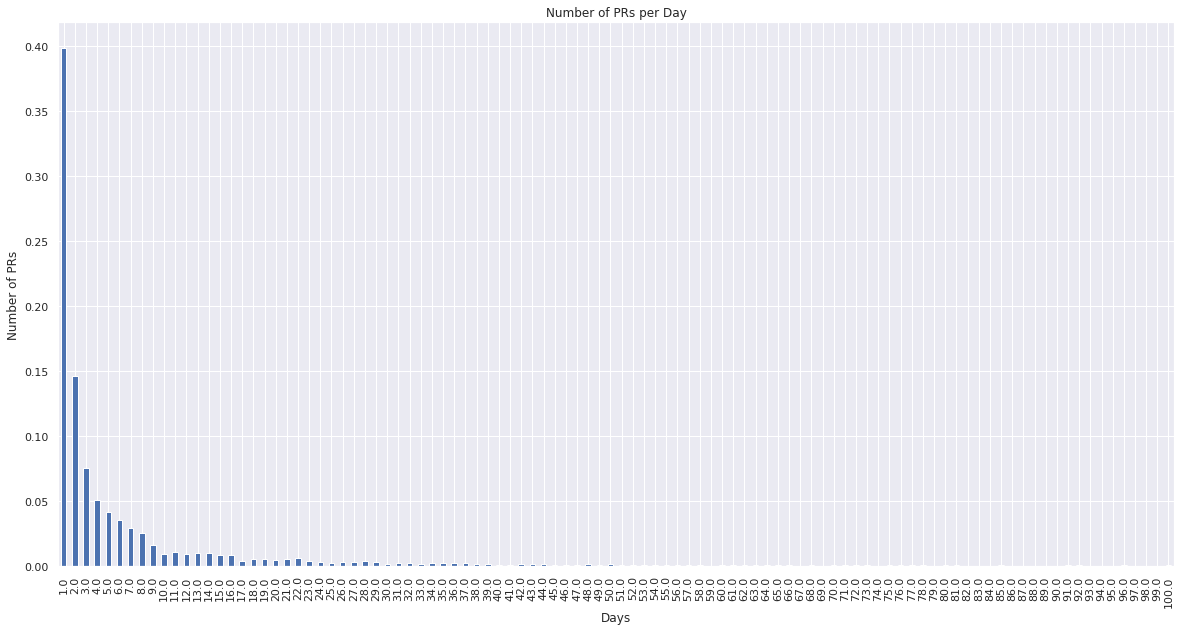

In [15]:
# only plot top 100 values so that graph is legible
nvc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("Days")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per Day")
plt.show()

From the above graph we can see that if we bucket the data into days, then roughly 40% of the data points would have the value "1", 15% would have the value "2" and so on. Therefore we need to select a finer granularity. 

In [16]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.098670
2.0      0.080414
3.0      0.054619
4.0      0.038655
8.0      0.034812
           ...   
813.0    0.000074
480.0    0.000074
428.0    0.000074
797.0    0.000074
667.0    0.000074
Name: time_to_merge, Length: 691, dtype: float64

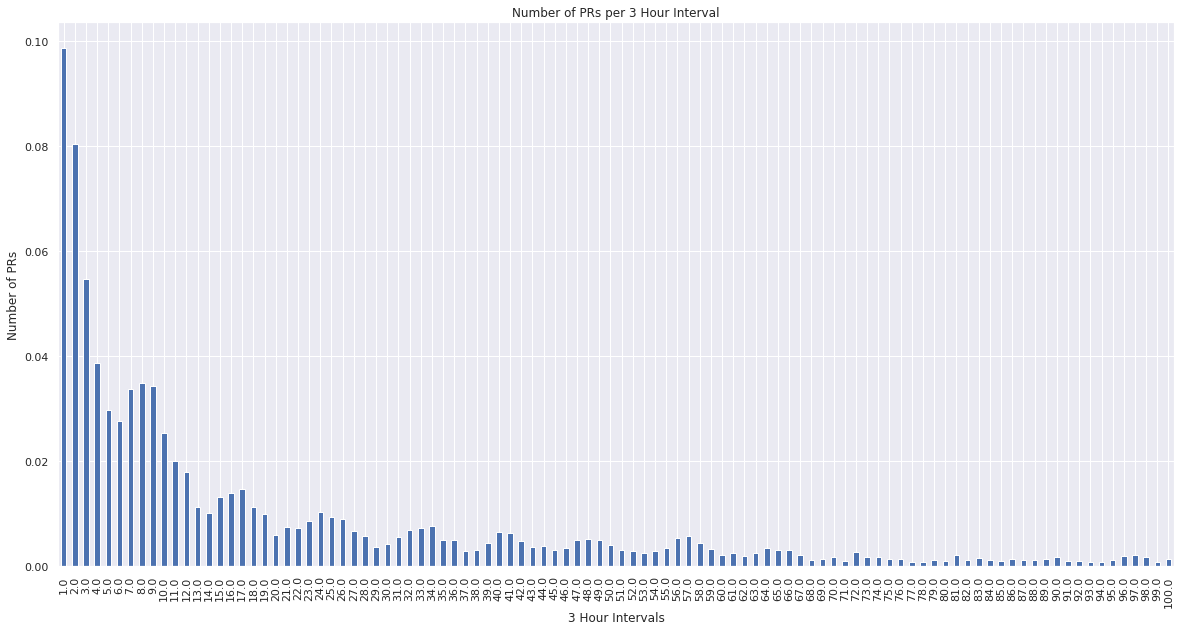

In [17]:
# only plot top 100 values so that graph is legible
nvc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("3 Hour Intervals")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per 3 Hour Interval")
plt.show()

From the above outputs we can see that if we bucket the data into 3 hours, then roughly 10% of the data points would have the value "1", 10% would have the value "2", 5% would have the value 3, and so on. This is a slightly better value distribution than before, but could be made even better. Lets explore what this would look like with an "hours" granularity.

In [18]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

3.0       0.034368
2.0       0.034368
4.0       0.030007
1.0       0.029933
5.0       0.026829
            ...   
2106.0    0.000074
1207.0    0.000074
4171.0    0.000074
811.0     0.000074
2671.0    0.000074
Name: time_to_merge, Length: 1314, dtype: float64

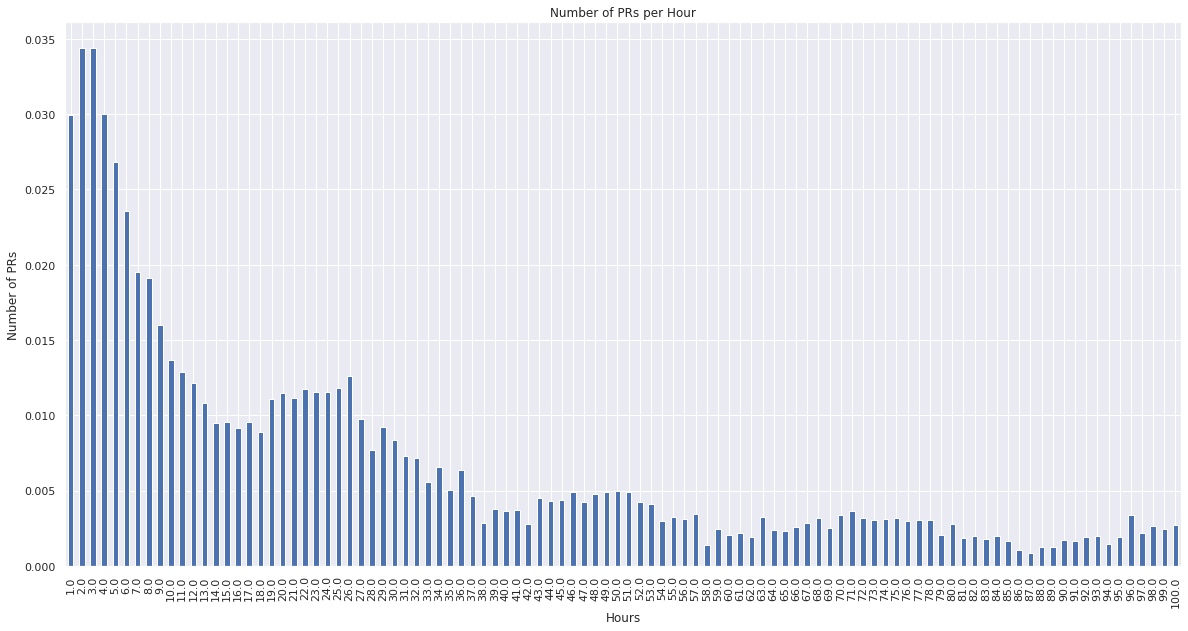

In [19]:
# only plot top 100 values so that graph is legible
nvc.sort_index().iloc[:100].plot(kind="bar")
plt.xlabel("Hours")
plt.ylabel("Number of PRs")
plt.title("Number of PRs per Hour")
plt.show()

From the above outputs we can see that if we bucket the data into hours, then roughly 3% of the data points would have the value "2", 3% would have the value "3", 3% would have the value "4", and so on. This seems like a reasonable distribution of values for a regression problem, since the data does not get skewed towards any one particular value.

As we make it more granular (e.g. minutes), the distribution would get even more uniform. However, a granularity finer than 1 hour might not provide any additional value to the end user. So we will go with granularity of 1 hour for our regression setup.

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [20]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0      0.000833
0.1      3.055000
0.2      7.060056
0.3     14.783722
0.4     24.154278
0.5     36.940833
0.6     65.870667
0.7    112.790861
0.8    191.135000
0.9    462.285278
Name: time_to_merge, dtype: float64

In [21]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0           NaN
0.1      3.054167
0.2      4.005056
0.3      7.723667
0.4      9.370556
0.5     12.786556
0.6     28.929833
0.7     46.920194
0.8     78.344139
0.9    271.150278
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, we can use the above buckets to define the classes. That is, class 0 is "merged within 3 hours", class 1 is "merged within 3-7 hours", etc.

Based on the EDA so far, we cannot conclusively reject either classification or regression. We can explore both of these approaches in depth in forthcoming notebooks and re-evaluate the best setup for this problem.

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [22]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [23]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [24]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,time_to_merge,body_size
26100,bug 1949306: add e2e test to block usage of re...,Right now this is set to flake in CI and provi...,XXL,deads2k,1619104429,1619253940,openshift-merge-robot,1619253940,2,135,"{'deads2k': 1, 'openshift-ci-robot': 307, 'stt...",{},"[approved, bugzilla/severity-urgent, bugzilla/...","[13b0e99d5f35d85998af9f07eb0c5b7d6fcc0dd0, 0c3...","[go.mod, go.sum, test/extended/apiserver/api_r...",149511.0,37
26099,bug 1951705: allow HighOverallControlPlaneCPU ...,adding the alert in https://github.com/openshi...,XS,deads2k,1619091511,1619113470,openshift-merge-robot,1619113470,1,1,"{'openshift-ci-robot': 508, 'deads2k': 43, 'op...",{},"[approved, bugzilla/severity-high, bugzilla/va...",[7bc10c83eea29010f3b735c41847d43a992f606c],[test/extended/prometheus/prometheus.go],21959.0,30


**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [25]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

26100    bug 1949306  add e2e test to block usage of re...
26099    bug 1951705  allow highoverallcontrolplanecpu ...
26098    refactor testmultipleimagechangebuildtriggers ...
26097    wip  monitor  move  crashlooping pods  test to...
26096                    bug 1949050  fix images sh script
                               ...                        
5                            add examples for pod creation
4                  wip  added project template json schema
3                        added etcd folder into  gitignore
2                              add alpha api documentation
1                    add link to gopath doc and fixup typo
Name: title, Length: 17183, dtype: object

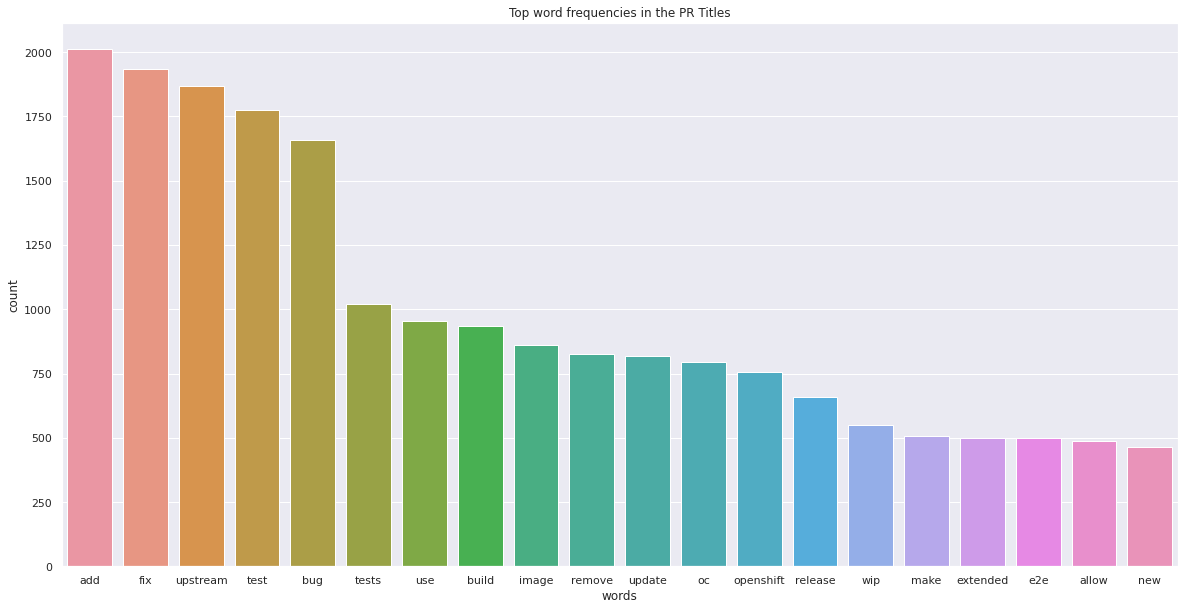

In [26]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

# plot the 20 most common words
sns.barplot(
    x=vc.index[:20],
    y=vc.values[:20],
)
plt.title("Top word frequencies in the PR Titles")
plt.xlabel("words")
plt.ylabel("count")
plt.show()

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [27]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

100%|██████████| 7828/7828 [04:02<00:00, 32.22it/s]


In [28]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

In [29]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,time_to_merge,body_size,title_word_counts_vec
26100,bug 1949306: add e2e test to block usage of re...,Right now this is set to flake in CI and provi...,XXL,deads2k,1619104429,1619253940,openshift-merge-robot,1619253940,2,135,"{'deads2k': 1, 'openshift-ci-robot': 307, 'stt...",{},"[approved, bugzilla/severity-urgent, bugzilla/...","[13b0e99d5f35d85998af9f07eb0c5b7d6fcc0dd0, 0c3...","[go.mod, go.sum, test/extended/apiserver/api_r...",149511.0,37,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
26099,bug 1951705: allow HighOverallControlPlaneCPU ...,adding the alert in https://github.com/openshi...,XS,deads2k,1619091511,1619113470,openshift-merge-robot,1619113470,1,1,"{'openshift-ci-robot': 508, 'deads2k': 43, 'op...",{},"[approved, bugzilla/severity-high, bugzilla/va...",[7bc10c83eea29010f3b735c41847d43a992f606c],[test/extended/prometheus/prometheus.go],21959.0,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Created By**

Is the time taken to merge a PR affected by the author of the PR? E.g. if a code reviewer or someone who has already made several contributions to a repo creates a PR, is it likely to get merged relatively faster?

In [30]:
# approvers and reviewers list from the repo
approvers = [
    "bparees",
    "deads2k",
    "derekwaynecarr",
    "eparis",
    "knobunc",  # Network, Multi-cluster, Storage
    "mfojtik",
    "pweil-",
    "sjenning",
    "soltysh",
    "sttts",
    "smarterclayton",
]

reviewers = [
    "bparees",
    "deads2k",
    "sjenning",
    "smarterclayton",
    "soltysh",
]

In [31]:
# is the pr creator on the approvers or reviewers list
pr_df["is_reviewer"] = pr_df["created_by"].isin(reviewers)
pr_df["is_approver"] = pr_df["created_by"].isin(approvers)

In [32]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,time_to_merge,body_size,title_word_counts_vec,is_reviewer,is_approver
26100,bug 1949306: add e2e test to block usage of re...,Right now this is set to flake in CI and provi...,XXL,deads2k,1619104429,1619253940,openshift-merge-robot,1619253940,2,135,"{'deads2k': 1, 'openshift-ci-robot': 307, 'stt...",{},"[approved, bugzilla/severity-urgent, bugzilla/...","[13b0e99d5f35d85998af9f07eb0c5b7d6fcc0dd0, 0c3...","[go.mod, go.sum, test/extended/apiserver/api_r...",149511.0,37,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,True
26099,bug 1951705: allow HighOverallControlPlaneCPU ...,adding the alert in https://github.com/openshi...,XS,deads2k,1619091511,1619113470,openshift-merge-robot,1619113470,1,1,"{'openshift-ci-robot': 508, 'deads2k': 43, 'op...",{},"[approved, bugzilla/severity-high, bugzilla/va...",[7bc10c83eea29010f3b735c41847d43a992f606c],[test/extended/prometheus/prometheus.go],21959.0,30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,True


We also want to derive a feature called `num_prev_merged_prs` captures the number of PRs that the creator created before this PR.

In [33]:
# how many prs did the creator create before this pr
def get_prev_pr_info(creator_pr_df):
    num_prev_merged_prs = (
        creator_pr_df["time_to_merge"].expanding().count().shift(1).fillna(0)
    )
    return num_prev_merged_prs


# need to sort before applying groupby
# because merging is not possible as df index types are different
pr_df = pr_df.sort_values(by="created_at")

num_prev_merged_prs = pr_df.groupby("created_by").apply(get_prev_pr_info)
num_prev_merged_prs = num_prev_merged_prs.reset_index(drop=True).rename("num_prev_prs")

pr_df["num_prev_merged_prs"] = num_prev_merged_prs.values

In [34]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,...,reviews,labels,commits,changed_files,time_to_merge,body_size,title_word_counts_vec,is_reviewer,is_approver,num_prev_merged_prs
1,Add link to GOPATH doc and fixup typo,None,XS,jwforres,1407759383,1407759502,smarterclayton,1407759502,1,1,...,{},[],[3c15fd6dd7cee58393feb786fd7876b6f22fe9b5],[README.md],119.0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0
2,Add alpha API documentation,Merge of csrwng/oo-api-v3\n,XXL,csrwng,1407834992,1407844533,danmcp,1407844533,1,54,...,{},[],[24acb7993293e311e8c1f76f4b17791998c2f391],"[api/README.md, api/build_flow.odg, api/doc/co...",9541.0,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0


**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [35]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
)
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())

# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [36]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,...,body_size,title_word_counts_vec,is_reviewer,is_approver,num_prev_merged_prs,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
1,Add link to GOPATH doc and fixup typo,None,XS,jwforres,1407759383,1407759502,smarterclayton,1407759502,1,1,...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,2014-08-11 12:16:23,11,8,0,12
2,Add alpha API documentation,Merge of csrwng/oo-api-v3\n,XXL,csrwng,1407834992,1407844533,danmcp,1407844533,1,54,...,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,2014-08-12 09:16:32,12,8,1,9


**Commits Number**  
Commits Number gives the number of commits created within the PR. This could be a numerical feature for our model.

In [37]:
pr_df.commits_number.value_counts()

1       13304
2        1986
3         737
4         353
5         234
        ...  
97          1
108         1
112         1
115         1
1718        1
Name: commits_number, Length: 105, dtype: int64

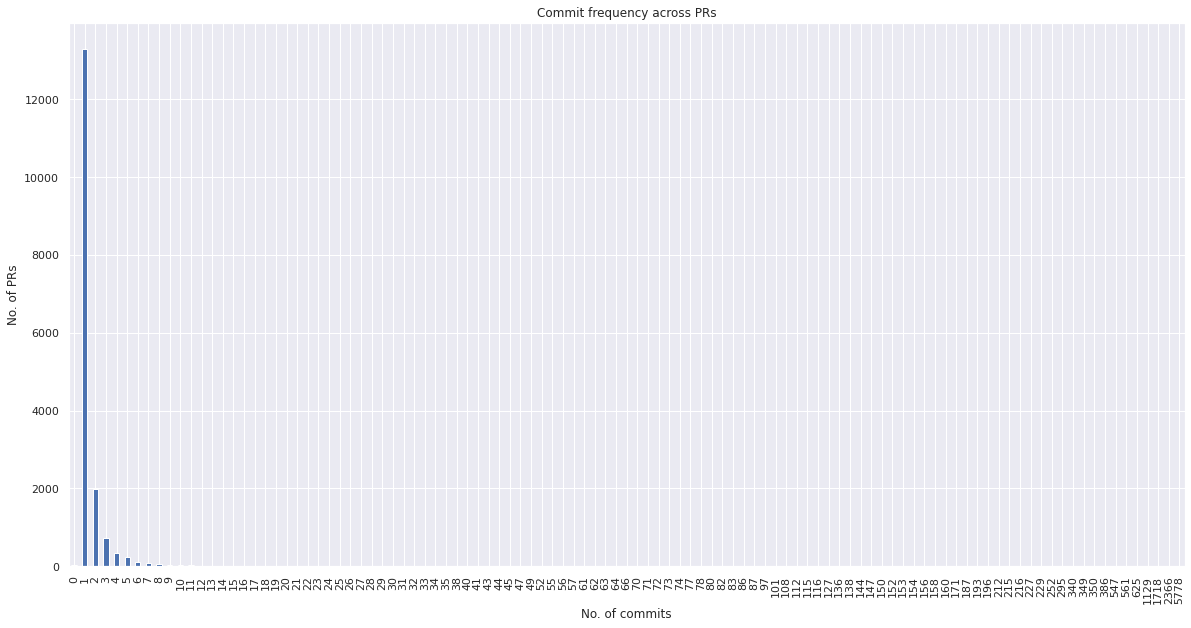

In [38]:
pr_df.commits_number.value_counts().sort_index(ascending=True).plot(kind="bar")
plt.title("Commit frequency across PRs")
plt.xlabel("No. of commits")
plt.ylabel("No. of PRs")
plt.show()

As we see above, in this dataset, there is not much variability in the commits number. Majority of the PRs (77%) have 1 commit, 11% have 2 commits and rest(12%) have more than 2 commits. We can break commits number down into 3 categorical variables, `contains_1_commit`, `contains_2_commits`, `contains_3_or_more_commits`. However, there might be some value in knowing whether a PR had 5 commits vs. 10 commits. So we will treat it as a numerical variable to begin with.

In [39]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,...,body_size,title_word_counts_vec,is_reviewer,is_approver,num_prev_merged_prs,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
1,Add link to GOPATH doc and fixup typo,None,XS,jwforres,1407759383,1407759502,smarterclayton,1407759502,1,1,...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,2014-08-11 12:16:23,11,8,0,12
2,Add alpha API documentation,Merge of csrwng/oo-api-v3\n,XXL,csrwng,1407834992,1407844533,danmcp,1407844533,1,54,...,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,2014-08-12 09:16:32,12,8,1,9


**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [40]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1        6151
2        3046
3        1622
4        1035
5         669
         ... 
12608       1
294         1
166         1
102         1
14041       1
Name: changed_files_number, Length: 422, dtype: int64

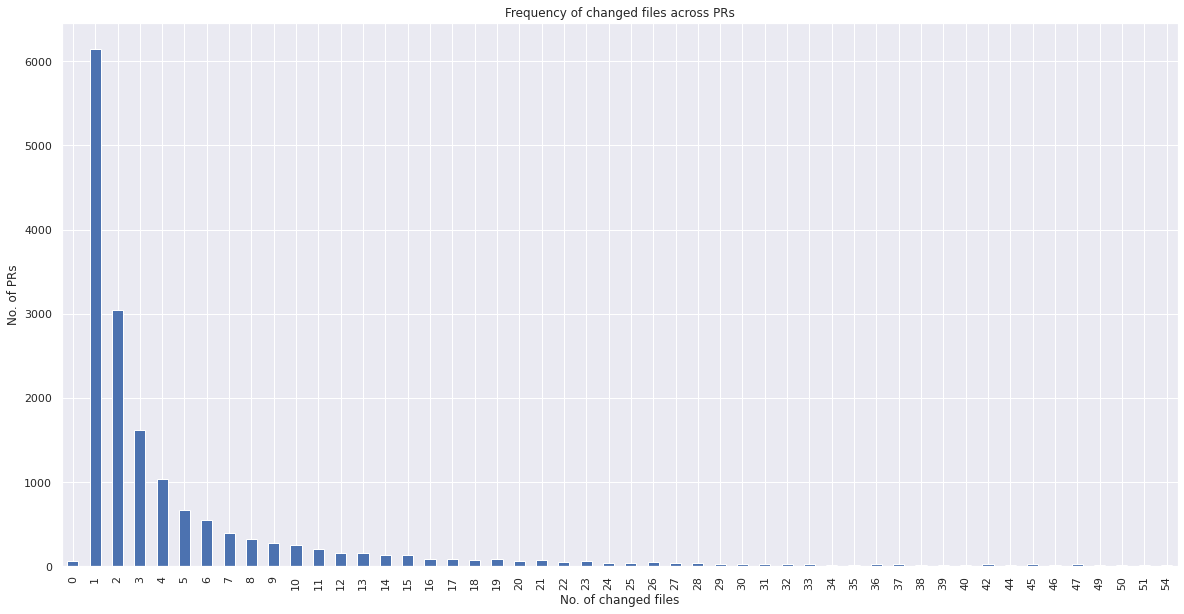

In [41]:
pr_df.changed_files_number.value_counts().iloc[:50].sort_index(ascending=True).plot(
    kind="bar"
)
plt.title("Frequency of changed files across PRs")
plt.xlabel("No. of changed files")
plt.ylabel("No. of PRs")
plt.show()

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [42]:
pr_df.changed_files[7]

['pkg/template/example/project.json',
 'pkg/template/generator.go',
 'pkg/template/generator/from_url.go',
 'pkg/template/generator/generator.go',
 'pkg/template/generator/template.go',
 'pkg/template/generator_test.go',
 'pkg/template/service_links.go',
 'pkg/template/service_links_test.go',
 'pkg/template/types.go']

In [43]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [44]:
# get list of all file types that were modified across all openshift origin PRs
changed_files = list(pr_df["changed_files"])

In [45]:
all_changed_files = [filetype(filepath) for pr in changed_files for filepath in pr]

In [46]:
count = Counter(all_changed_files)

In [47]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [48]:
top_fileextensions

['.go',
 '.json',
 '.1',
 '.sh',
 '.md',
 '.yaml',
 'BUILD',
 '.proto',
 '.yml',
 'OWNERS',
 '.html',
 '.adoc',
 'Dockerfile',
 '.js',
 'LICENSE',
 'Makefile',
 '.txt',
 '.gitignore',
 'oc',
 '.pem',
 '.s',
 '.mod',
 'openshift',
 '.lock',
 '.py',
 '.sum',
 '.conf',
 '.bats',
 '.png',
 '.less',
 '.pb',
 '.feature',
 '.xml',
 '.tar',
 '.crt',
 '.spec',
 '.template',
 'AUTHORS',
 '.service',
 '.key',
 'run',
 '.mk',
 '.scss',
 '.golden',
 'oadm',
 '.rhel',
 '.cert',
 'result',
 '.original',
 '.h',
 '.toml',
 '.dat',
 '.edited',
 'MAINTAINERS',
 '.svg',
 '.in',
 '.text',
 'README',
 '.cfg',
 '.cc',
 'NOTICE',
 '.c',
 '.bash',
 '.pl',
 'Vagrantfile',
 '.chain',
 '.centos7',
 'CONTRIBUTORS',
 '.gz',
 'cert',
 'key',
 '.swift',
 '.csr',
 '.files_generated_oc',
 '.sc',
 'Readme',
 '.tmpl',
 '.empty',
 '.insecure',
 '.hcl',
 'PATENTS',
 '.files_generated_openshift',
 '.sec',
 None,
 'VERSION',
 '.css',
 '.ini',
 'Procfile',
 '.ber',
 '.env',
 '.sls',
 '.mailmap',
 '.markdown',
 'test',
 '.com'

In [49]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [50]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [51]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,...,title_word_counts_vec,is_reviewer,is_approver,num_prev_merged_prs,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
1,Add link to GOPATH doc and fixup typo,None,XS,jwforres,1407759383,1407759502,smarterclayton,1407759502,1,1,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,2014-08-11 12:16:23,11,8,0,12,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Add alpha API documentation,Merge of csrwng/oo-api-v3\n,XXL,csrwng,1407834992,1407844533,danmcp,1407844533,1,54,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,2014-08-12 09:16:32,12,8,1,9,"[0, 47, 0, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


In [52]:
# We will also create a categorical variable for a modification in
# each of the directories present in the openshift origins repo

directories = [
    ".github",
    "cmd",
    "docs",
    "e2echart",
    "examples",
    "hack",
    "images",
    "pkg",
    "test",
    "tools",
    "vendor",
    "root",
]

In [53]:
def directory_from_filepath(list_of_filepaths):

    directories = []
    for filepath in list_of_filepaths:
        if "/" in filepath:
            directories.append(filepath.split("/", 1)[0])
        else:
            directories.append("root")

    return directories

In [54]:
# does the PR make a change to the given directory
pr_df["change_in_.github"] = pr_df["changed_files"].apply(
    lambda x: 1 if ".github" in directory_from_filepath(x) else 0
)
pr_df["change_in_cmd"] = pr_df["changed_files"].apply(
    lambda x: 1 if "cmd" in directory_from_filepath(x) else 0
)
pr_df["change_in_docs"] = pr_df["changed_files"].apply(
    lambda x: 1 if "docs" in directory_from_filepath(x) else 0
)
pr_df["change_in_e2echart"] = pr_df["changed_files"].apply(
    lambda x: 1 if "e2echart" in directory_from_filepath(x) else 0
)
pr_df["change_in_examples"] = pr_df["changed_files"].apply(
    lambda x: 1 if "examples" in directory_from_filepath(x) else 0
)
pr_df["change_in_hack"] = pr_df["changed_files"].apply(
    lambda x: 1 if "hack" in directory_from_filepath(x) else 0
)
pr_df["change_in_images"] = pr_df["changed_files"].apply(
    lambda x: 1 if "images" in directory_from_filepath(x) else 0
)
pr_df["change_in_pkg"] = pr_df["changed_files"].apply(
    lambda x: 1 if "pkg" in directory_from_filepath(x) else 0
)
pr_df["change_in_test"] = pr_df["changed_files"].apply(
    lambda x: 1 if "test" in directory_from_filepath(x) else 0
)
pr_df["change_in_tools"] = pr_df["changed_files"].apply(
    lambda x: 1 if "tools" in directory_from_filepath(x) else 0
)
pr_df["change_in_vendor"] = pr_df["changed_files"].apply(
    lambda x: 1 if "vendor" in directory_from_filepath(x) else 0
)
pr_df["change_in_root"] = pr_df["changed_files"].apply(
    lambda x: 1 if "root" in directory_from_filepath(x) else 0
)

In [55]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,commits_number,changed_files_number,...,change_in_docs,change_in_e2echart,change_in_examples,change_in_hack,change_in_images,change_in_pkg,change_in_test,change_in_tools,change_in_vendor,change_in_root
1,Add link to GOPATH doc and fixup typo,None,XS,jwforres,1407759383,1407759502,smarterclayton,1407759502,1,1,...,0,0,0,0,0,0,0,0,0,1
2,Add alpha API documentation,Merge of csrwng/oo-api-v3\n,XXL,csrwng,1407834992,1407844533,danmcp,1407844533,1,54,...,0,0,0,0,0,0,0,0,0,0


We can see above that some PRs have 0 for all directory fields since the directory structure of the repo has changed over time and we are interested in only the latest directory structure.

-----------------------------------

## Correlation Analysis

Let's look at some pair-wise scatter plots of our data to see if there are any obvious correlations between our features. 

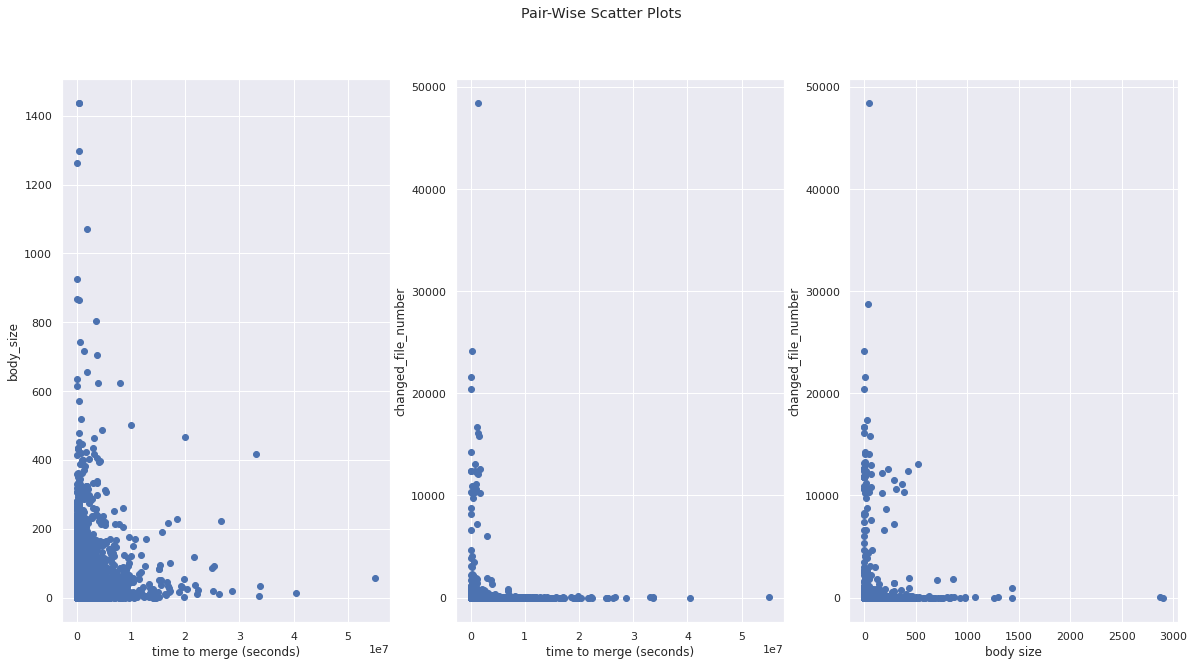

In [56]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(pr_df["time_to_merge"], pr_df["body_size"])
ax1.set(xlabel="time to merge (seconds)", ylabel="body_size")
ax2.scatter(pr_df["time_to_merge"], pr_df["changed_files_number"])
ax2.set(xlabel="time to merge (seconds)", ylabel="changed_file_number")
ax3.scatter(pr_df["body_size"], pr_df["changed_files_number"])
ax3.set(xlabel="body size", ylabel="changed_file_number")
fig.suptitle("Pair-Wise Scatter Plots")
plt.show()

Its tough to see any meaningfull correlations here. Despite this "L" shaped scatter plot the vast majority of the points are centered around (0,0) in all 3 cases. Let's calculate the correlation value for each pair of variables to see some actaul numbers.

In [58]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "title_word_counts_vec",
        "is_reviewer",
        "is_approver",
        "num_prev_merged_prs",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
        "change_in_.github",
        "change_in_cmd",
        "change_in_docs",
        "change_in_e2echart",
        "change_in_examples",
        "change_in_hack",
        "change_in_images",
        "change_in_pkg",
        "change_in_test",
        "change_in_tools",
        "change_in_vendor",
        "change_in_root",
    ]
]

In [59]:
feature_df.head(2)

,time_to_merge,changed_files_number,body_size,title_word_counts_vec,is_reviewer,is_approver,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,...,change_in_docs,change_in_e2echart,change_in_examples,change_in_hack,change_in_images,change_in_pkg,change_in_test,change_in_tools,change_in_vendor,change_in_root
1,119.0,1,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,11,8,0,...,0,0,0,0,0,0,0,0,0,1
2,9541.0,54,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",False,False,0.0,12,8,1,...,0,0,0,0,0,0,0,0,0,0


In [60]:
feature_df.describe()

,time_to_merge,changed_files_number,body_size,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour,change_in_.github,change_in_cmd,change_in_docs,change_in_e2echart,change_in_examples,change_in_hack,change_in_images,change_in_pkg,change_in_test,change_in_tools,change_in_vendor,change_in_root
count,1.353000e+04,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000,17183.000000
mean,6.801719e+05,68.379910,31.476867,229.372752,15.567479,6.286970,2.128557,13.720829,0.000698,0.026363,0.040622,0.000349,0.057091,0.124600,0.052959,0.511727,0.310947,0.014084,0.165396,0.085433
std,1.848350e+06,885.774654,66.186398,322.057245,8.731051,3.314852,1.531857,5.323008,0.026418,0.160218,0.197418,0.018684,0.232024,0.330274,0.223959,0.499877,0.462895,0.117839,0.371548,0.279534
min,3.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.684875e+04,1.000000,3.000000,19.000000,8.000000,3.000000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.329870e+05,2.000000,14.000000,87.000000,16.000000,6.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,5.245955e+05,6.000000,36.000000,289.000000,23.000000,9.000000,3.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,5.500529e+07,48386.000000,2899.000000,1429.000000,31.000000,12.000000,6.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
feature_df.corr()

,time_to_merge,changed_files_number,body_size,is_reviewer,is_approver,num_prev_merged_prs,created_at_day,created_at_month,created_at_weekday,created_at_hour,...,change_in_docs,change_in_e2echart,change_in_examples,change_in_hack,change_in_images,change_in_pkg,change_in_test,change_in_tools,change_in_vendor,change_in_root
time_to_merge,1.000000,0.004417,0.115515,-0.096736,-0.102332,-0.018753,0.004760,0.032109,0.008868,-0.005521,...,0.064161,-0.003522,-0.012264,-0.008334,0.052237,0.006355,0.076274,0.011415,0.043098,0.013162
changed_files_number,0.004417,1.000000,0.028810,0.022640,0.038375,-0.009828,0.012326,-0.005190,0.001103,-0.004093,...,0.108738,-0.001102,0.111870,0.120545,0.064884,0.017680,0.060799,0.297162,0.101134,0.143168
body_size,0.115515,0.028810,1.000000,-0.046570,-0.038743,-0.014049,0.003230,-0.010040,0.004392,-0.004478,...,0.051589,0.002783,-0.035196,0.032767,0.034976,0.061880,0.086399,0.022451,-0.016925,-0.021174
is_reviewer,-0.096736,0.022640,-0.046570,1.000000,0.834052,0.020988,0.021690,-0.029429,0.055555,0.031581,...,-0.003584,0.015755,0.035323,0.097542,-0.048938,0.063370,0.094600,0.032614,0.022099,0.007114
is_approver,-0.102332,0.038375,-0.038743,0.834052,1.000000,0.019125,0.018469,-0.039007,0.026221,-0.025437,...,-0.004837,0.011703,0.031128,0.096303,-0.039032,0.055353,0.069149,0.033465,0.052098,0.010770
num_prev_merged_prs,-0.018753,-0.009828,-0.014049,0.020988,0.019125,1.000000,-0.018976,-0.099265,-0.003266,-0.000345,...,-0.041726,-0.013137,-0.064679,0.027780,-0.036691,0.013441,0.020455,0.005067,-0.022072,0.002253
created_at_day,0.004760,0.012326,0.003230,0.021690,0.018469,-0.018976,1.000000,-0.056522,-0.009328,-0.019063,...,-0.002401,0.006634,0.005726,-0.002785,0.004244,-0.004799,0.013709,0.004846,0.007109,0.000762
created_at_month,0.032109,-0.005190,-0.010040,-0.029429,-0.039007,-0.099265,-0.056522,1.000000,-0.023644,-0.010134,...,0.033768,-0.014774,0.004577,0.012631,-0.007694,-0.025230,0.025137,-0.010943,0.013583,0.030634
created_at_weekday,0.008868,0.001103,0.004392,0.055555,0.026221,-0.003266,-0.009328,-0.023644,1.000000,-0.064876,...,-0.002643,-0.013770,-0.001984,0.011706,-0.004918,-0.006567,0.009202,0.006413,0.001497,0.024367
created_at_hour,-0.005521,-0.004093,-0.004478,0.031581,-0.025437,-0.000345,-0.019063,-0.010134,-0.064876,1.000000,...,-0.009201,-0.006627,-0.017442,0.001778,0.012744,0.028845,-0.001757,-0.005051,-0.008316,-0.004662


From the correlation values, above we do not see any strong correlation between `time to merge` and other variables. We can see that body_size is _most_ correlated with time_to_merge, but 0.11 is a rather weak correlation value. This is good if we are going to use these as input features to a model, but not so good if we wanted to try and predict one value from the other two.  As next [steps](https://github.com//issues/281), we will explore the correlation between the features in further detail to select the most important features for our model.

### Conlusion

This notebook walked through how to access the relevant PR data for the OpenShift Origin project we whish to analyze along with the rest of the related CI data in this project. We also outlined what is contained in each record and provided a quick demonstration of how to convert the mixed data types into numerical values for statistical analysis and eventually machine learning. 

We also engineered some possible features which can be used to predict time to merge of a PR. 


- time_to_merge: time taken to merge a PR in seconds, this is feature we will try to predict
- changed_files_number: integer indicating the number of files changed, this is an available column
- body_size: integer indicating the number of words in the body of the PR, derived from body
- title_word_counts_vec: vector or list indicating how many times each word appeared in the title
- is_reviewer: categorical variable indicating whether the creator of the PR is a reviewer, derived from created_by and additional repo data
- is_approver: categorical variable indicating whether the creator of the PR is an approver, derived from created_by and additional repo data
- num_prev_merged_prs: categorical variable indicating whether the creator of the PR has previously created PRs, derived from created_by
- created_at_day: categorical variable indicating the day of month the PR has been created, derived from created_at
- created_at_month: categorical variable indicating the month of the year that the PR has been created, derived from created_at
- created_at_weekday: categorical variable indicating the day of the week the PR has been created, derived from created_at
- created_at_hour: categorical variable indicating the hour of the day the PR has been created, derived from created_at
- commits_number: integer indicating the number of commiyts in the PR
- changed_file_type_vec":  vector or list consisting of number of files changed for the top 100 most frequently occuring datatypes, derived from changed_files
- change_in_.github": categorical variable indicating whether the PR changes a file in the .github directory, derived from changed_files
- change_in_cmd": categorical variable indicating whether the PR changes a file in the cmd directory, derived from changed_files 
- change_in_docs": categorical variable indicating whether the PR changes a file in the docs directory, derived from changed_files 
- change_in_e2echart": categorical variable indicating whether the PR changes a file in the e2echart directory, derived from changed_files 
- change_in_examples": categorical variable indicating whether the PR changes a file in the examples directory, derived from changed_files 
- change_in_hack": categorical variable indicating whether the PR changes a file in the hack directory, derived from changed_files 
- change_in_images": categorical variable indicating whether the PR changes a file in the images directory, derived from changed_files 
- change_in_pkg: categorical variable indicating whether the PR changes a file in the pkg directory, derived from changed_files 
- change_in_test: categorical variable indicating whether the PR changes a file in the test directory, derived from changed_files 
- change_in_tools": categorical variable indicating whether the PR changes a file in the tools directory, derived from changed_files 
- change_in_vendor": categorical variable indicating whether the PR changes a file in the vendor directory, derived from changed_files 
- change_in_root": categorical variable indicating whether the PR changes a file in the root directory of the repo, derived from changed_files 

As next steps, we will evaluate the importance of the defined features and train a machine learning model to predict time to merge of a PR using the features.